# Image Inpainting with Generative Adversarial Networks: Visualization

This Jupyter notebooks serves as a supplement for running the model and visualizing the results of our model.

In [1]:
!python -VV

Python 3.9.13 (main, Oct 13 2022, 21:23:06) [MSC v.1916 64 bit (AMD64)]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random

In [3]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from train import load_model
from utils.masks import initialize_masks

# Preprocessing the Data

First, since our application utilizes the CIFAR-100 dataset, we retrieve the dataset. Afterwards, for every runthrough, data is augmented via an augmentation function (namely a random flip and a change in the image's contrast). The below code can be found in 'train.py' and 'inpainter.py', though it is included here for reference.

In [4]:
# This code can be found in 'train.py'. It is included here for reference.
def get_data():
    (training_images, _), (test_images, _) = tf.keras.datasets.cifar100.load_data()
    return training_images, test_images

augment_fn = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal_and_vertical"),
            tf.keras.layers.RandomContrast(0.10)
        ])

# This code can be found in 'inpainter.py'. 
def get_mini_batch(images, batch_size):
    batch = []
    indices = set()
    # collects a batch of unique indices from images (the entire training dataset)
    while (len(indices) < batch_size):
        indices.add(random.randint(0, len(images)-1))
    for idx in indices:
        batch.append(images[idx])
    return tf.convert_to_tensor(batch)

# This code can be found in 'masks.py'.
def initialize_masks(batch_size, image_size, window_size, hole_min, hole_max, num_holes=1):
    # list of tuples (mask + location of mask if the number of holes is 1)
    # (not concerned with locations of the masks when there are multiple holes, which only happens during testing)
    masks = []
    locations = []
    for i in range(batch_size):
        mask = np.zeros((image_size, image_size, 1), dtype=np.uint8)
        for j in range(num_holes):
            hole_w, hole_h = np.random.randint(hole_min, hole_max + 1, 2)
            hole_x = np.random.randint(0, window_size - hole_w + 1)
            hole_y = np.random.randint(0, window_size - hole_h + 1)
            mask[hole_x: (hole_x + hole_w), hole_y: (hole_y + hole_h)] = 1
            if (num_holes == 1):
                locations += [[hole_x, hole_y, hole_w, hole_h]]
        masks += [mask]
    if (num_holes == 1):
        return np.array(masks), np.array(locations)
    else:
        return np.array(masks), None

We first apply the data augmentations and masks. Within the training step, we mask the augmented images to use as training for the GAN.

In [5]:
batch_size = 10
images, test_images = get_data()
M_C, locations_C = initialize_masks(batch_size, images.shape[1], int(images.shape[1]/2), int(images.shape[1]/2), int(images.shape[1]/2))

original_images = get_mini_batch(images, batch_size)
augmented_images = augment_fn(original_images)
masked_images = tf.cast(augmented_images * (1 - M_C), dtype=tf.float32)

original_images = tf.cast(original_images, dtype=tf.float32)
augmented_images = tf.cast(augmented_images, dtype=tf.float32)
masked_images = tf.cast(masked_images, dtype=tf.float32)

We can now visualize a few images before and after the inpainting process.

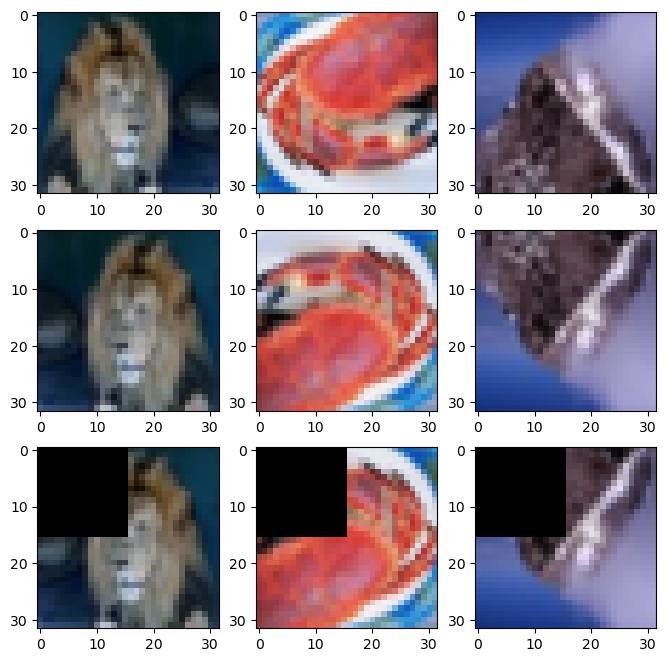

In [6]:
sample_image_indices = [0, 1, 2]
sample_images = tf.cast(tf.gather(original_images, sample_image_indices), tf.float32)

fig, ax = plt.subplots(3, 3)
fig.set_size_inches(8, 8)

for i in range(3):
    ax[0][i].imshow(original_images[i]/255., cmap = "Greys")
    ax[1][i].imshow(augmented_images[i]/255., cmap = "Greys")
    ax[2][i].imshow(masked_images[i]/255., cmap = "Greys")

# Training the Model
Further details for the model can be found in the README as well as the model report. This 
notebookwill serve as a high level overview of the model's functionality and a visualization 
of the outputs.

We are running the training process elsewhere with a stronger GPU, so the below code will
load the saved model and display the test statistics.

In [7]:
model = load_model('./model')
# Testing block please here
from train import compile_model
compile_model(model)
model.test(test_images)

 Testing 10000/10000 // avg_loss: 2631423.0318078124 dice_coeff (acc) : 0.4770976692706705Training Summary: average completion loss=2631423.032 // average accuracy = 0.477

Following the training of the model, we can once again visualize the performance of the model.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


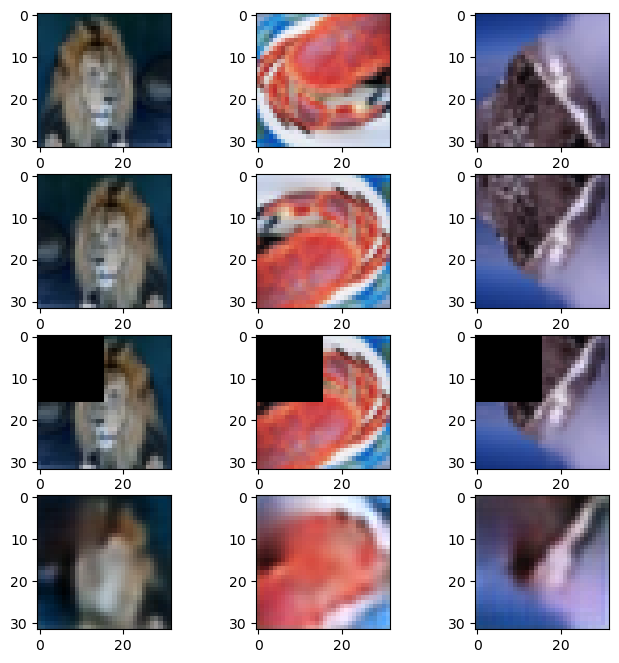

In [8]:
sample_image_indices = [0, 1, 2]
sample_images = tf.cast(tf.gather(original_images, sample_image_indices), tf.float32)
generated_images = model(masked_images)

fig, ax = plt.subplots(4, 3)
fig.set_size_inches(8, 8)

for i in range(3):
    ax[0][i].imshow(original_images[i]/255., cmap = "Greys")
    ax[1][i].imshow(augmented_images[i]/255., cmap = "Greys")
    ax[2][i].imshow(masked_images[i]/255., cmap = "Greys")
    ax[3][i].imshow(generated_images[i]/255., cmap = "Greys")